In [1]:
import h5py, sys, os
import numpy as np
from scipy import ndimage
import scipy
from matplotlib import pyplot as plt
from matplotlib import animation
from datetime import datetime
from matplotlib import colors
print(os.getcwd())

# PyDMD imports
from pydmd import DMD, BOPDMD, FbDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

print(base_dir)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves
/store/ATMOS/cwp29/data/waves/N_175/512/


In [2]:
#Load simulation data
w, b, phi, times = load_data('w_xz', 'th1_xz', 'th2_xz')
b -= b[0] # subtract initial profile so b is perturbation b
NSAMP = len(times)

print(w.shape)

times, t0_idx = calibrate_time(save_dir, times)

tstart_idx = get_index(10, times)
tend_idx = get_index(20, times)

#zplot = 0.4
zmin = 0.15
zmax = 0.4
zmin_idx = get_index(zmin, gzf)
zmax_idx = get_index(zmax, gzf)

phi_contour = 1e-3
xlims = (0.1, 0.5)
clim = 1e-3

# Choose data window
w = w[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
b = b[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
phi = phi[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
times = times[tstart_idx:tend_idx+1]

# Filter out timesteps
print(len(times))
filter_step = 2
times = times[::filter_step]
ntimes = len(times)
print(len(times))

snapshots = [w[::filter_step][i] for i in range(len(times))]
phi_snapshots = [phi[::filter_step][i] for i in range(len(times))]
print(len(snapshots))

X, Y = np.meshgrid(gx, gz[zmin_idx-1:zmax_idx+1])
Xf, Yf = np.meshgrid(gxf, gzf[zmin_idx:zmax_idx+1])

Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
(180, 513, 512)
Plume penetration occured at t=2.4639
100
50
50


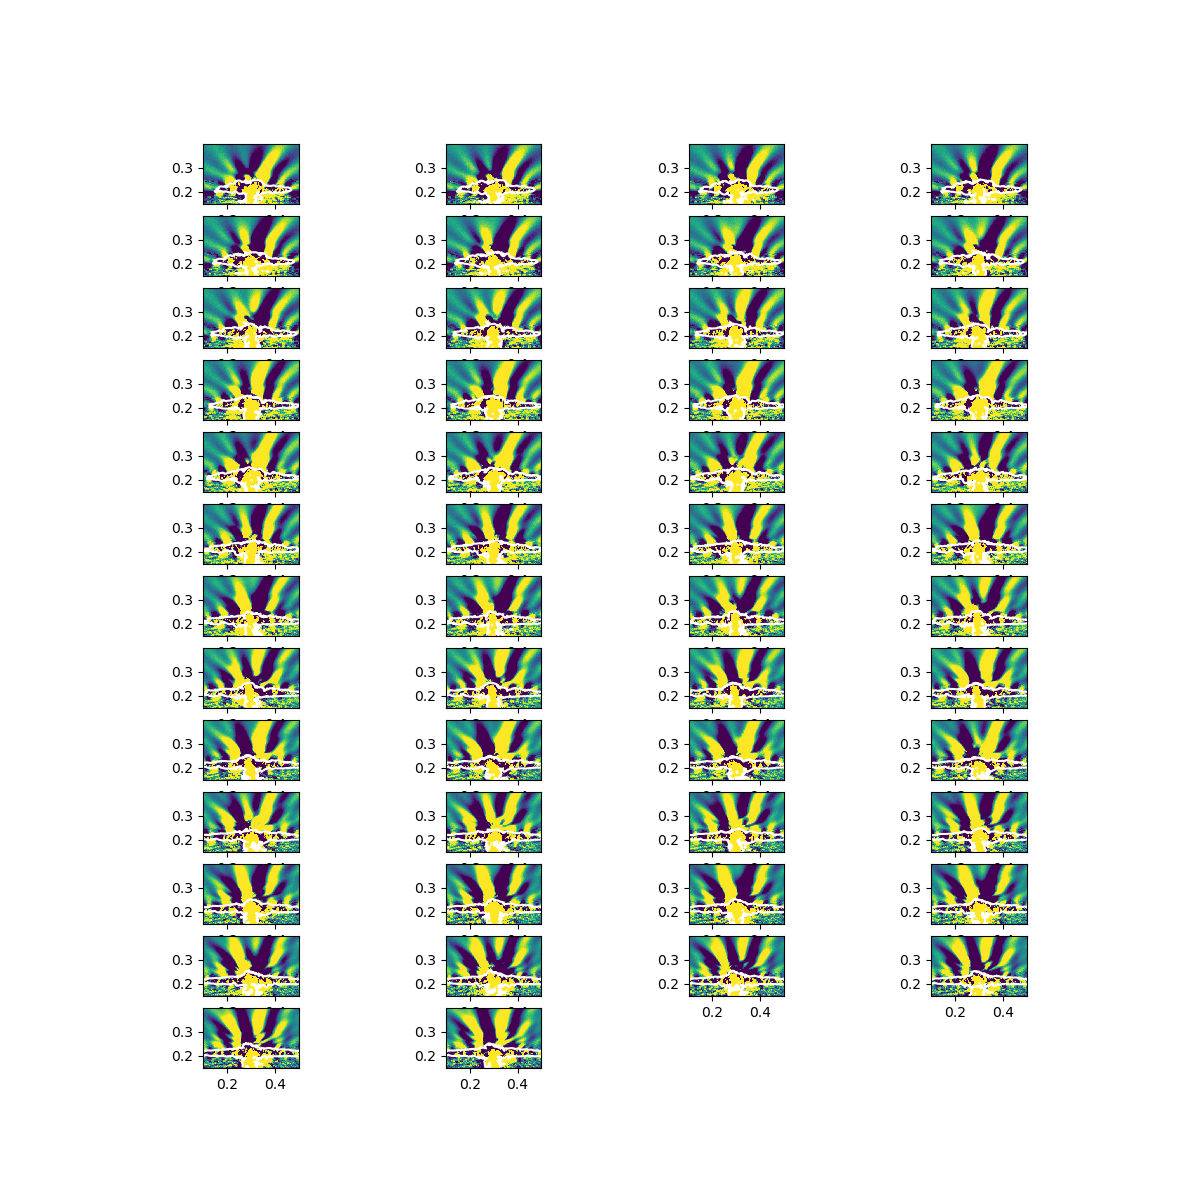

In [3]:
fig = plt.figure(figsize=(12,12))
ncol = 4
if len(snapshots) % ncol != 0:
    rnum = len(snapshots)//ncol + 1
else:
    rnum = len(snapshots)//ncol
    
for id_subplot, snapshot in enumerate(snapshots, start=1):
    plt.subplot(rnum, ncol, id_subplot)
    plt.pcolormesh(X, Y, snapshot, vmin=-clim, vmax=clim)
    plt.contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='w')
    plt.xlim(*xlims)
    plt.gca().set_aspect(1)

In [4]:
#dmd = DMD(svd_rank=8, tlsq_rank=2, exact=True, opt=True)
#dmd = BOPDMD(svd_rank=0, num_trials=0, eig_constraints={"imag", "conjugate_pairs"})
dmd = FbDMD(exact=True)
dmd.fit(snapshots)#, times)

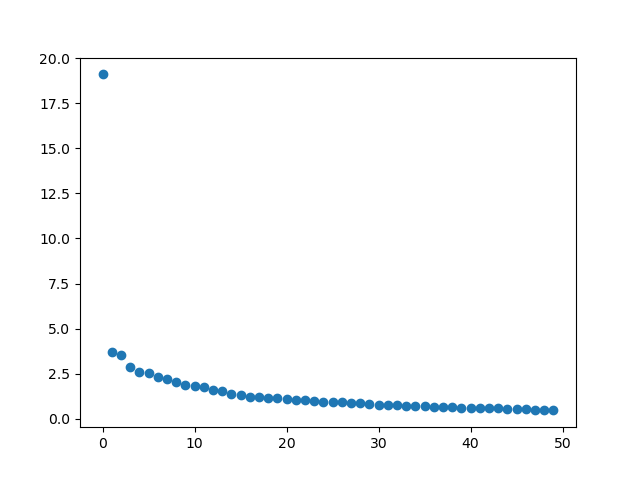

In [5]:
fig3 = plt.figure()
plt.plot(
    scipy.linalg.svdvals(
        np.array([snapshot.flatten() for snapshot in snapshots]).T
    ),
    "o",
)
plt.show()

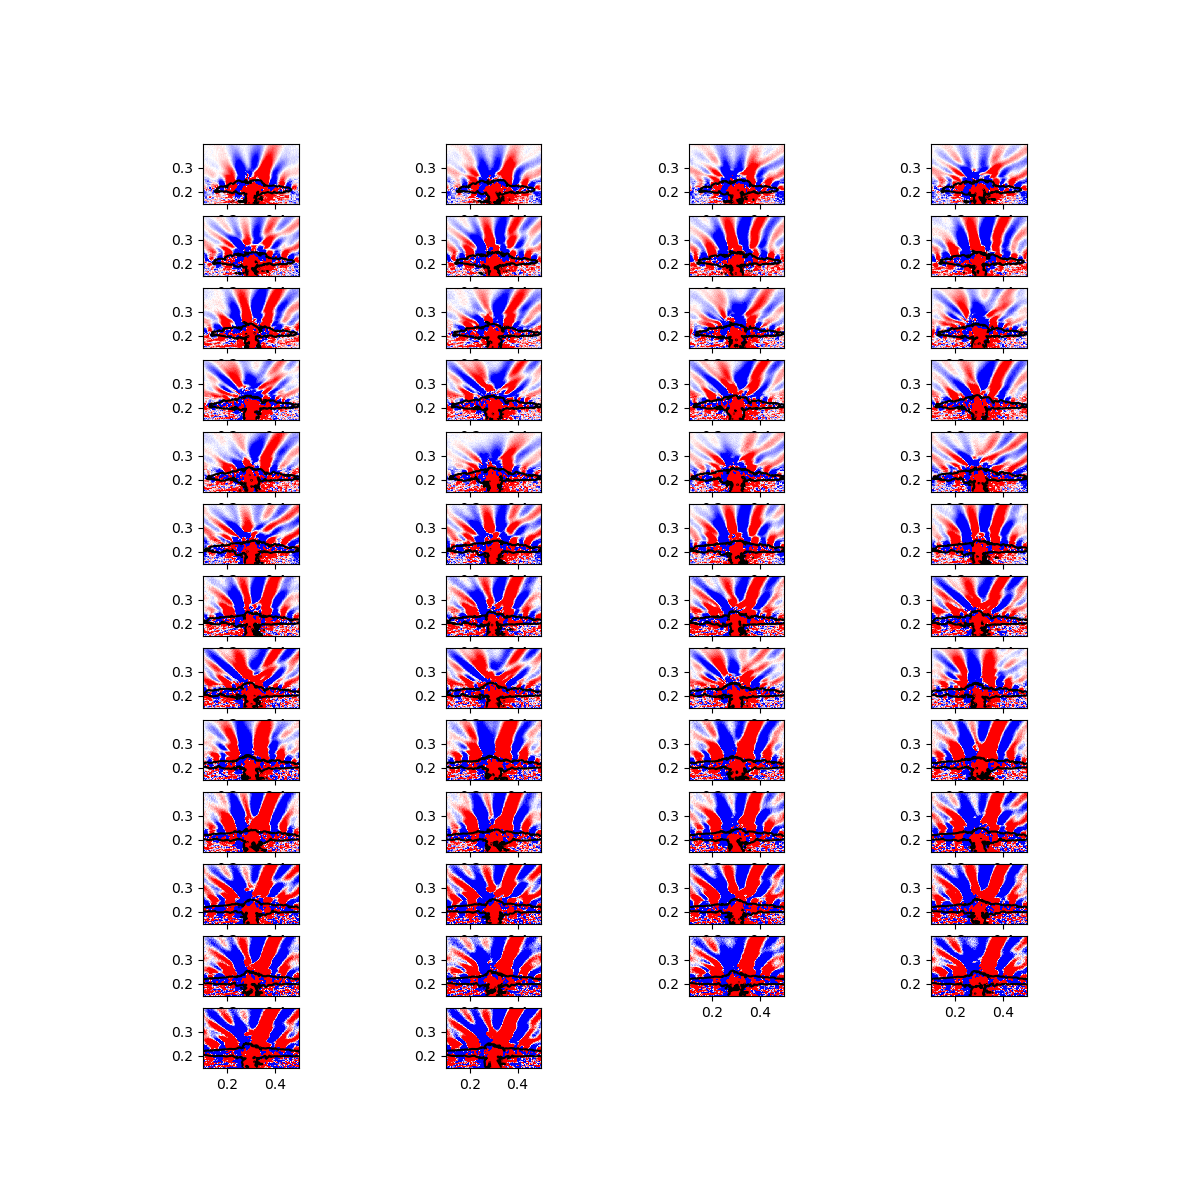

In [6]:
fig4 = plt.figure(figsize=(12, 12))
for id_subplot, snapshot in enumerate(dmd.reconstructed_data.T, start=1):
    plt.subplot(rnum, ncol, id_subplot)
    plt.pcolormesh(
        X, Y, snapshot.reshape(w[0].shape).real, vmin=-clim, vmax=clim,
        cmap='bwr'
    )
    plt.contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='k')
    plt.xlim(*xlims)
    plt.gca().set_aspect(1)

/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/pydmd/plotter.py:195: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(


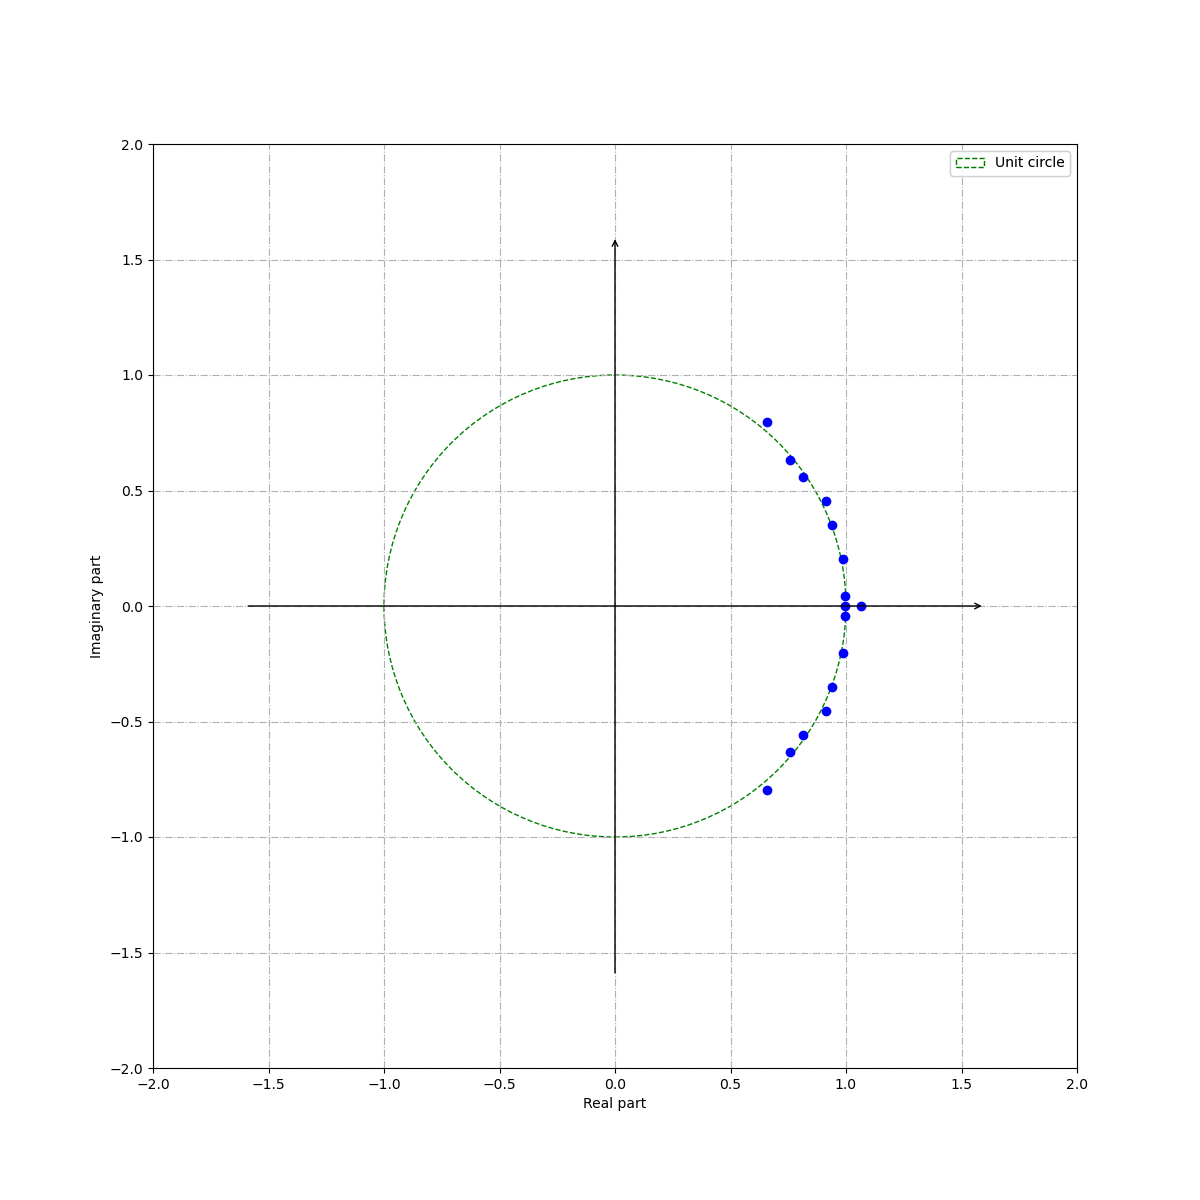

In [7]:
plot_eigs(dmd, figsize=(12, 12))

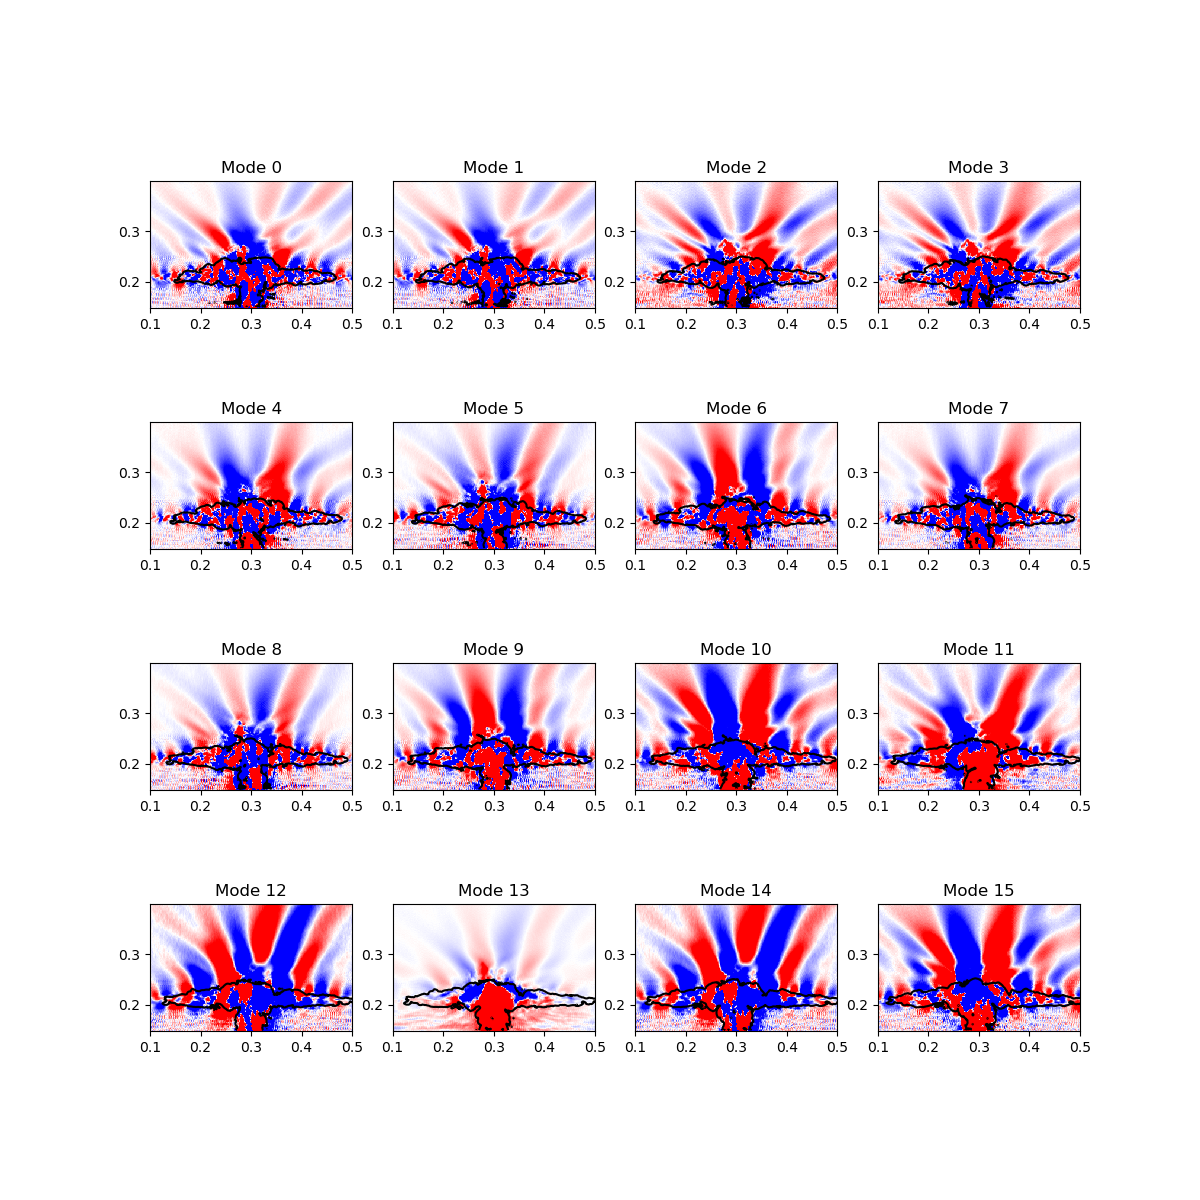

In [8]:
#modes = dmd.modes.reshape((w[0].shape[0], w[0].shape[1], dmd.modes.shape[-1]))
modes = np.moveaxis(dmd.modes, -1, 0)
nmodes = len(modes)

ncol_modes = 4
if nmodes % ncol_modes != 0:
    rnum_modes = nmodes//ncol_modes + 1
else:
    rnum_modes = nmodes//ncol_modes

fig6 = plt.figure(figsize=(12, 12))
for id_subplot, snapshot in enumerate(modes, start=1):
    plt.subplot(rnum_modes, ncol_modes, id_subplot)
    plt.pcolormesh(X, Y, snapshot.reshape(w[0].shape).real, vmin=-clim, vmax=clim, cmap='bwr')
    plt.contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='k')
    plt.xlim(*xlims)
    plt.gca().set_title("Mode {0}".format(id_subplot-1))
    plt.gca().set_aspect(1)

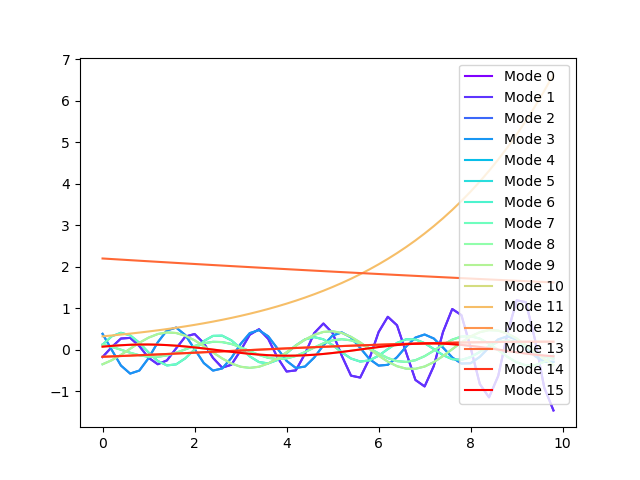

In [9]:
# Plot modes over time
fig7 = plt.figure()
cols = plt.cm.rainbow(np.linspace(0, 1, nmodes))
for n, line in enumerate(dmd.dynamics.real):
    plt.plot(dmd.dmd_timesteps*md['SAVE_STATS_DT_FINE']*filter_step,
             line, label = "Mode {0}".format(n), color=cols[n])

plt.legend()

In [10]:
# Reconstructed data
time_evol = dmd.dynamics
modes = modes.reshape((nmodes, *w[0].shape))
reconstructed = np.zeros_like(snapshots, dtype=np.complex128)
for i in range(len(times)):
    nmodes_r = 1
    for j in range(0,nmodes_r):
        reconstructed[i] += time_evol[j,i] * modes[j]
        
reconstructed = np.real(reconstructed)

#reconstructed = dmd.reconstructed_data.T.real.reshape(len(times), *w[0].shape)
print(reconstructed.shape)

(50, 214, 512)


Setting up data arrays...
Setting up initial plot...
Initialising mp4 writer...
Starting plot...


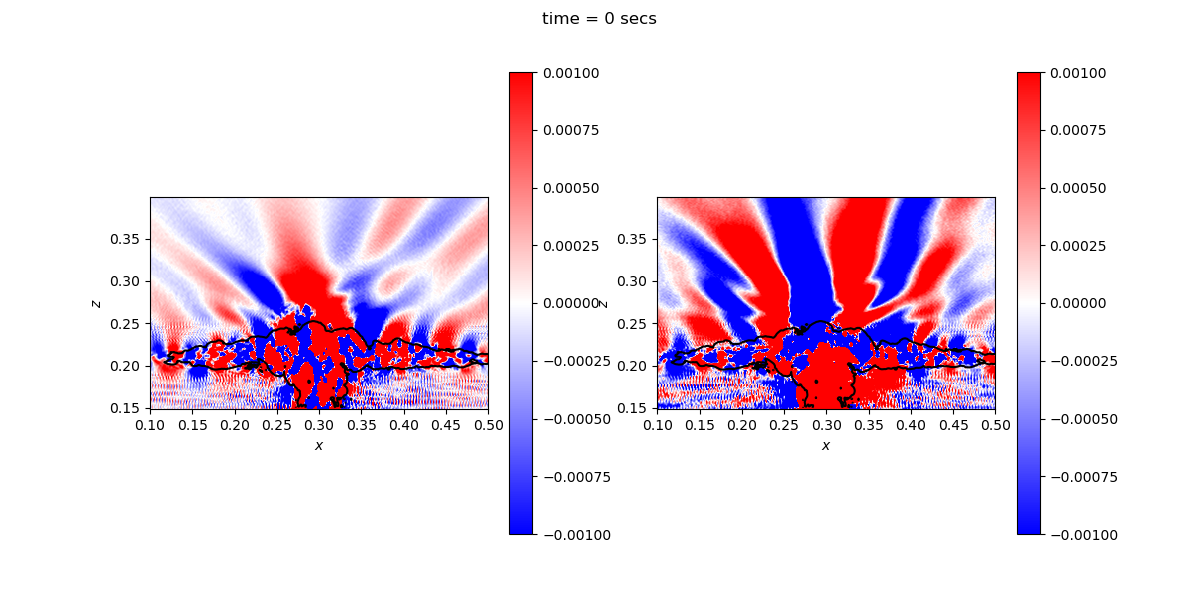

In [11]:
# Comparison movie
print("Setting up data arrays...")
fig, axs = plt.subplots(1,2, figsize=(12,6))
ims = np.array([None,None])
cb = np.array([None,None])

print("Setting up initial plot...")
ims[0] = axs[0].pcolormesh(X, Y, reconstructed[-1], cmap='bwr', norm=colors.CenteredNorm())
ims[1] = axs[1].pcolormesh(X, Y, snapshots[-1], cmap='bwr', norm=colors.CenteredNorm())
axs[0].contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='k')
axs[1].contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='k')

cb[0] = plt.colorbar(ims[0],ax=axs[0])
cb[1] = plt.colorbar(ims[1],ax=axs[1])

ims[0].set_clim(-clim, clim)
ims[1].set_clim(-clim, clim)

axs[0].set_xlim(*xlims)
axs[1].set_xlim(*xlims)

fig.suptitle("time = 0 secs")
axs[0].set_ylabel("$z$")
axs[1].set_ylabel("$z$")
axs[0].set_xlabel("$x$")
axs[1].set_xlabel("$x$")

axs[0].set_aspect(1)
axs[1].set_aspect(1)

def animate(step):
    ims[0].set_array(reconstructed[step].ravel())
    ims[1].set_array(snapshots[step].ravel())
    fig.suptitle("time = {0:.2f} secs".format(times[step]))

    return ims.flatten(),

print("Initialising mp4 writer...")
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, bitrate=1800)

print("Starting plot...")
anim = animation.FuncAnimation(fig, animate, interval=500, frames=len(times), repeat=True)
now = datetime.now()
plt.show()

In [12]:
#Characteristic frequencies
print(np.imag(np.round(np.log(dmd.eigs) / md['SAVE_STATS_DT_FINE'], decimals=12)))

[ 8.79036817 -8.79036817  6.93802806 -6.93802806  6.00541571  4.60691073
  3.58192554 -6.00541571 -4.60691073 -3.58192554  2.03117399  0.
  0.45548952 -0.         -0.45548952 -2.03117399]
